In [186]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import RandomizedSearchCV

from skrub import GapEncoder
from skrub import Cleaner, TableReport
from skrub import StringEncoder, MinHashEncoder, TableVectorizer, TextEncoder

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import KBinsDiscretizer

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer

import sys
sys.path.append('../src/')
from qto_categorizer_ml.io import datasets
from matplotlib import pyplot as plt

Ideas:
- Creer des embeddings à partir d'un modèle sur étagère: https://skrub-data.org/stable/auto_examples/02_text_with_string_encoders.html
  - Gap Encoder:
    from skrub import GapEncoder
    gap = GapEncoder(n_components=30)
    X_trans = gap.fit_transform(X["text"])
    X_trans.insert(0, "text", X["text"])
    TableReport(X_trans)
  - MinHashEncoder 
  - TextEncoder
  - SringEncoder
  - TFidf?
- Quelles metriques?
  - Multiclass classification problem
    - accuracy score: accuracy(y_true, y_pred) -> simple a intepreter, biaisé avec des classes déséquilibrée
    - precision, recall, f1score : classification_report(y_true, y_pred)

In [234]:
dtypes = {
    'TRANSACTION_ID': str,
    'AMOUNT': float,
    'TYPE_OF_PAYMENT': str,
    'MERCHANT_NAME': str,
    'DESCRIPTION': str,
    'SIDE':  int,
    'CATEGORY': str,
}
parse_dates = ['DATE_EMITTED']

path = "../data/data-products.csv"
df = datasets.CSVReader(path=path, dtypes=dtypes, parse_dates=parse_dates).read()

# Replace missing values
df['MERCHANT_NAME'] = df.MERCHANT_NAME.fillna("No marchant")
df['DESCRIPTION'] = df.DESCRIPTION.fillna("No Description")
df['TYPE_OF_PAYMENT'] = df.TYPE_OF_PAYMENT.fillna("No type payment")

features = ['AMOUNT', 'TYPE_OF_PAYMENT', 'MERCHANT_NAME', 'DESCRIPTION']
target = 'CATEGORY'

X = df[features+[target]].drop_duplicates()
le = LabelEncoder()
y = le.fit_transform(X.pop(target))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [239]:
from sklearn.pipeline import make_pipeline

desc_pipe = make_pipeline(
    TfidfVectorizer(max_features=1000),
    TruncatedSVD(n_components=50, random_state=42)
)

merch_pipe = make_pipeline(
    TfidfVectorizer(max_features=500),
    TruncatedSVD(n_components=30, random_state=42)
)

type_pipe = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['AMOUNT']),
        ('cat', type_pipe, ['TYPE_OF_PAYMENT']),
        ('desc', desc_pipe , "DESCRIPTION"),
        ('merchant', merch_pipe , 'MERCHANT_NAME')
    ]
)

pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(n_estimators=200, max_depth=30, n_jobs=-1, random_state=42))
    ]
)

pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Choosing the right hyperparameters can significantly improve model performance. sklearn offers several methods for automated hyperparameter tuning: GridSearchCV, RandominzedCV, HalvingGridSearchCV, HalvingRandomSearchCV.
Best practices I used are: 
- Always combine these methods with cross-validation (cv parameter)
- Use n_jobs=-1 to parallelize the search
- Choose scoring metric based on the problem we want to solve (e.g. accuracy, f1_macro, roc_auc)

For the categorizer, I selected RandomizedSearchCV because it efficiently explore a wide hyperparameter space with fewer computations, making it ideal for the time-constrained searches.

In [224]:
param_grid ={
    'classifier__n_estimators': [50,100,200],
    'classifier__max_depth': [10, 20, 30, None]
}

grid_search = RandomizedSearchCV(
    pipeline,
    param_grid, 
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

grid_search.best_params_, grid_search.best_score_

({'classifier__n_estimators': 200, 'classifier__max_depth': 30},
 0.598390937434056)

In [240]:
%time
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

CPU times: user 5 μs, sys: 2 μs, total: 7 μs
Wall time: 14.1 μs


In [ ]:
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
acc

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

df['COMBINED'] = df.apply(lambda x: "Type of Payment: " + str(x['TYPE_OF_PAYMENT']) + "; Merchant Name: " + str(x['MERCHANT_NAME']) + "; Description: " + str(x['DESCRIPTION']), axis=1)
corpus = df.COMBINED.fillna("COMBINED").values
cv = CountVectorizer(max_features = 200)
X = cv.fit_transform(corpus).toarray()

le = LabelEncoder()
y = le.fit_transform(df[target])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

classifier = RandomForestClassifier(n_estimators = 200, random_state = 42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
acc

0.4160918994893814

In [158]:
X = df[features]
le = LabelEncoder()
y = le.fit_transform(df[target])

# Creating the Bag of Words model


# Splitting the dataset into the Training set and Test set
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# X_train['DESCRIPTION'] = X_train.DESCRIPTION.apply(lambda x: str(x).lower())
X_train['MERCHANT_NAME'] = X_train.MERCHANT_NAME.apply(lambda x: str(x).lower())
X_test['MERCHANT_NAME'] = X_test.MERCHANT_NAME.apply(lambda x: str(x).lower())


#X_train['MERCHANT_NAME'] = X_train.MERCHANT_NAME.fillna("No Marchant")

# remove non alphabetic caracters
X_train['DESCRIPTION'] = X_train.DESCRIPTION.fillna("No Description")
X_test['DESCRIPTION'] = X_test.DESCRIPTION.fillna("No Description")
#X_train['DESCRIPTION'] = X_train.DESCRIPTION.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))
#X_train['MERCHANT_NAME'] = X_train.MERCHANT_NAME.fillna("No Marchant")
#X_train['MERCHANT_NAME'] = X_train.DESCRIPTION.apply(lambda x: re.sub('[^a-zA-Z0-9]', ' ', x))

print(X_train.shape, X_test.shape)
X_train

(168618, 4) (168619, 4)


,AMOUNT,TYPE_OF_PAYMENT,MERCHANT_NAME,DESCRIPTION
198148,223.45,Credit Card,inpi,CARTE X4380 17/05 INPI VADS COMMERCE ELECTRONIQUE
2149,68.30,Transfer,bridge,la bellenergie - A202311308203 - BRIDGE
268210,3.77,Credit Card,carte bleue - fournitures petits équipements (...,Carte TAVERNIER - CONDIS SUPERMERCAT
187899,1916.35,Transfer,vocalex,000001 VIR EUROPEEN EMIS NET POUR: VOCALEX REF...
182251,1.33,Transfer,sas espagnac freres,No Description
...,...,...,...,...
150649,360.29,Transfer,distribution sanitaire chauffage,PAIEMENT CB 1201 LYON CEDEO VADS CARTE 7488
168218,1.35,Transfer,rent a car,CARBOOKR - 0202526943 - RENT A CAR
306545,33.08,Check,sarl rio a. - d.l.m.,CHEQUE EMIS 0994503
166198,3.62,Transfer,vistaprint b.v.,Carte Balducci - Vistaprint


In [98]:
pipeline_minhash = make_pipeline(
    TableVectorizer(high_cardinality=MinHashEncoder(n_components=30)),
    HistGradientBoostingClassifier(),
)
pipeline_minhash.fit(X_train, y_train)
pipeline_minhash

,steps,"[('tablevectorizer', ...), ('histgradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,cardinality_threshold,40
,low_cardinality,OneHotEncoder..._output=False)
,high_cardinality,MinHashEncoder()
,numeric,PassThrough()
,datetime,DatetimeEncoder()
,specific_transformers,()
,drop_null_fraction,1.0


In [99]:
y_pred = pipeline_minhash.predict(X_test)
#print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
acc

0.49194930583148994

In [44]:
#pipeline_gap = make_pipeline(
#    TableVectorizer(high_cardinality=GapEncoder(n_components=30)),
#    HistGradientBoostingClassifier(),
#)
#pipeline_gap.fit(X_train, y_train)

In [72]:
y_pred = pipeline_minhash.predict(X_test)
print(classification_report(y_test, y_pred))

/Users/corentinvasseur/Desktop/qto/qto-categorizer-ml/.venv/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns ['0', '1', …].
  warnings.warn(


              precision    recall  f1-score   support

           0       0.21      0.11      0.15      1715
           1       0.30      0.15      0.20      1134
           2       0.17      0.03      0.05       924
           3       0.67      0.09      0.15      2979
           4       0.89      0.41      0.56      3993
           5       0.32      0.06      0.10      7810
           6       0.12      0.10      0.11       156
           7       0.39      0.40      0.39       892
           8       0.35      0.15      0.21       398
           9       0.07      0.04      0.05       562
          10       0.07      0.07      0.07       327
          11       0.24      0.09      0.13       577
          12       0.03      0.16      0.05        90
          13       0.01      0.02      0.01       129
          14       0.31      0.23      0.26      8078
          15       0.00      0.00      0.00       370
          16       0.24      0.04      0.07      1126
          17       0.25    

/Users/corentinvasseur/Desktop/qto/qto-categorizer-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/corentinvasseur/Desktop/qto/qto-categorizer-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/corentinvasseur/Desktop/qto/qto-categorizer-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

In [46]:
string_encoder = StringEncoder()

pipeline_string = make_pipeline(
    TableVectorizer(high_cardinality=string_encoder),
    HistGradientBoostingClassifier(),
)
pipeline_string.fit(X_train, y_train)

,steps,"[('tablevectorizer', ...), ('histgradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,cardinality_threshold,40
,low_cardinality,OneHotEncoder..._output=False)
,high_cardinality,StringEncoder()
,numeric,PassThrough()
,datetime,DatetimeEncoder()
,specific_transformers,()
,drop_null_fraction,1.0


In [47]:
y_pred = pipeline_string.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.07      0.05      0.06      1715
           1       0.03      0.11      0.05      1134
           2       0.01      0.03      0.02       924
           3       0.17      0.12      0.14      2979
           4       0.76      0.29      0.42      3993
           5       0.19      0.02      0.04      7810
           6       0.00      0.18      0.01       156
           7       0.10      0.22      0.14       892
           8       0.01      0.08      0.01       398
           9       0.00      0.07      0.01       562
          10       0.03      0.24      0.05       327
          11       0.01      0.17      0.01       577
          12       0.00      0.01      0.00        90
          13       0.00      0.08      0.01       129
          14       0.19      0.04      0.07      8078
          15       0.00      0.02      0.00       370
          16       0.05      0.06      0.05      1126
          17       0.22    

In [137]:
text_encoder = TextEncoder(
    "sentence-transformers/paraphrase-albert-small-v2",
    device="cpu",
)

pipeline_text_encoder = make_pipeline(
    TableVectorizer(high_cardinality=text_encoder),
    HistGradientBoostingClassifier(),
)
pipeline_text_encoder.fit(X_train, y_train)

/Users/corentinvasseur/Desktop/qto/qto-categorizer-ml/.venv/lib/python3.10/site-packages/skrub/_check_input.py:169: UserWarning: Only pandas and polars DataFrames are supported, but input is a Numpy array. Please convert Numpy arrays to DataFrames before passing them to skrub transformers. Converting to pandas DataFrame with columns ['0', '1', …].
  warnings.warn(


,steps,"[('tablevectorizer', ...), ('histgradientboostingclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,cardinality_threshold,40
,low_cardinality,OneHotEncoder..._output=False)
,high_cardinality,TextEncoder(d...ert-small-v2')
,numeric,PassThrough()
,datetime,DatetimeEncoder()
,specific_transformers,()
,drop_null_fraction,1.0


In [138]:
## y_pred = pipeline_string.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.25      0.34      1715
           1       0.51      0.28      0.36      1134
           2       0.42      0.14      0.21       924
           3       0.38      0.22      0.28      2979
           4       0.85      0.56      0.67      3993
           5       0.37      0.27      0.31      7810
           6       0.59      0.33      0.42       156
           7       0.54      0.79      0.64       892
           8       0.46      0.27      0.34       398
           9       0.51      0.45      0.48       562
          10       0.52      0.23      0.31       327
          11       0.50      0.10      0.17       577
          12       0.32      0.13      0.19        90
          13       0.44      0.14      0.21       129
          14       0.35      0.35      0.35      8078
          15       0.31      0.03      0.05       370
          16       0.35      0.13      0.18      1126
          17       0.63    

/Users/corentinvasseur/Desktop/qto/qto-categorizer-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/corentinvasseur/Desktop/qto/qto-categorizer-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/corentinvasseur/Desktop/qto/qto-categorizer-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

In [22]:
# GapEncoder
gap = GapEncoder(n_components=30)
X_trans = gap.fit_transform(X_train.COMBINED)
# Add the original COMBINED as a first column
X_trans.insert(0, "COMBINED", X_train)
TableReport(X_trans)

Processing column  31 / 31


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


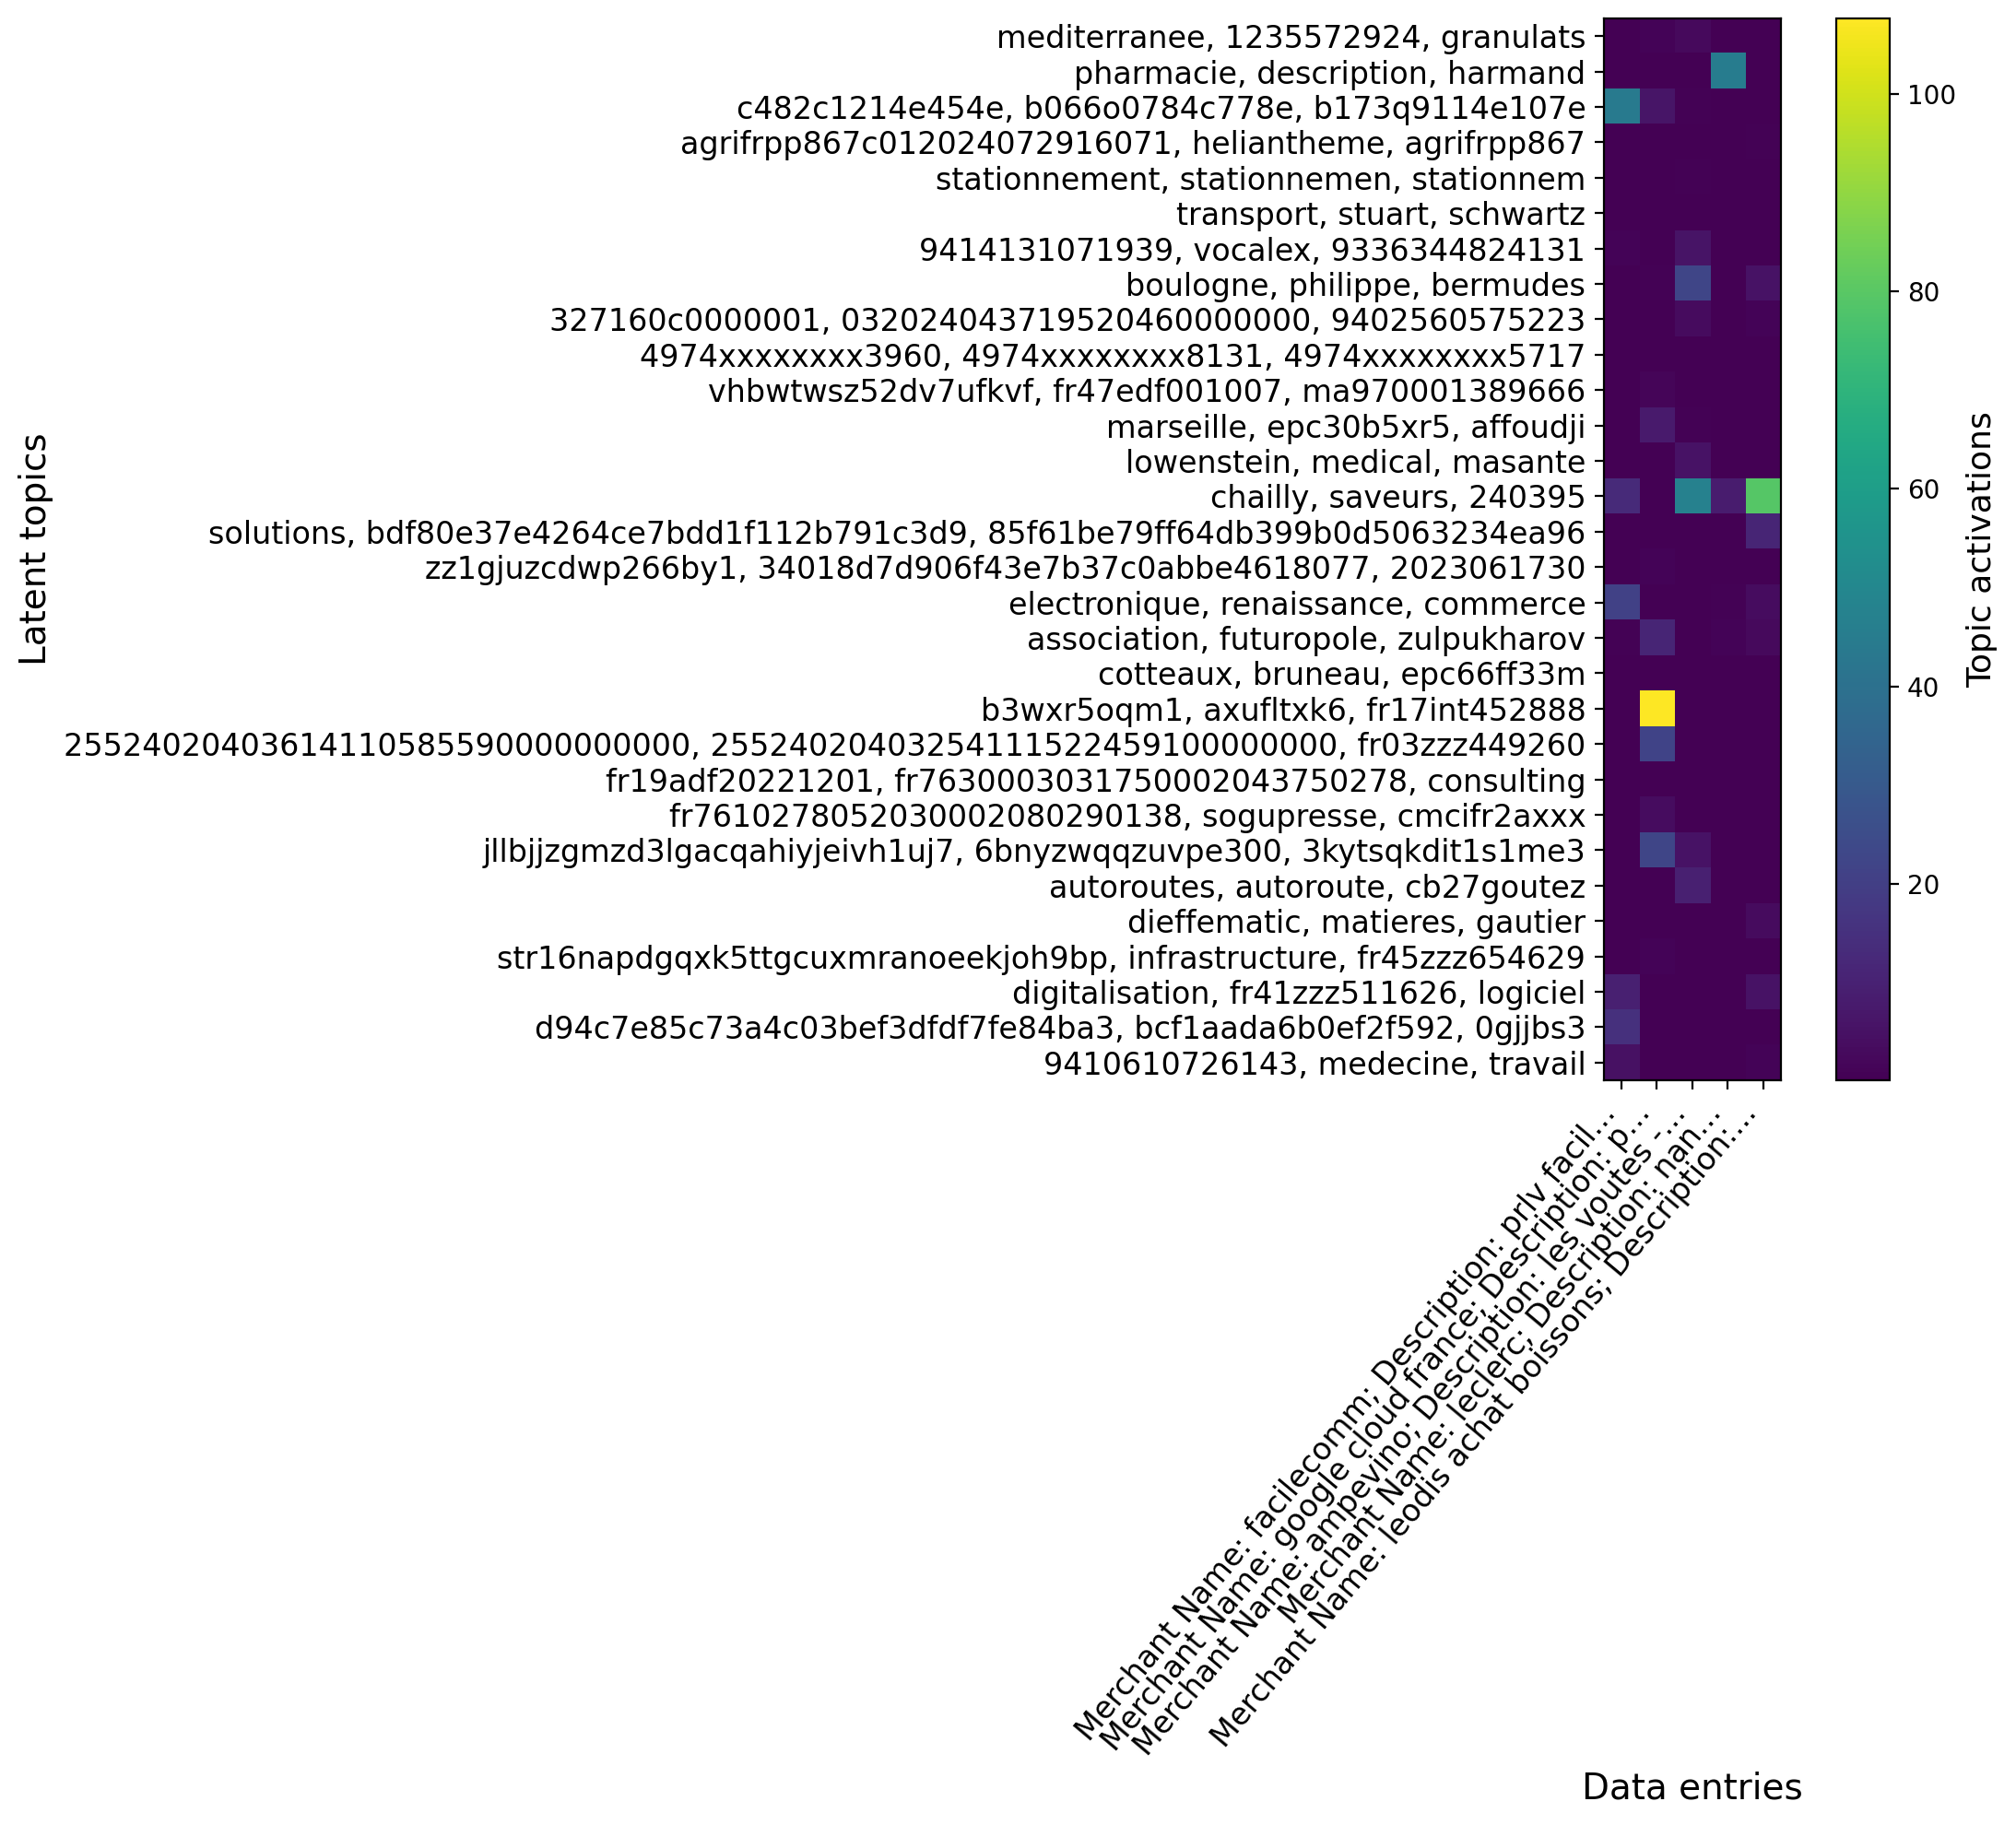

In [23]:
plot_gap_feature_importance(X_trans.head())

In [21]:
gap_pipe_fitted = make_pipeline(
    TableVectorizer(high_cardinality=GapEncoder(n_components=2)),
    HistGradientBoostingClassifier(),
).fit(X_train,y_train)

y_pred = gap_pipe.predict(X_test)
sum(y_test == y_pred)/len(y_test)

NameError: name 'gap_pipe' is not defined

## StringEncoder

In [ ]:
string_encoder = StringEncoder(ngram_range=(3, 4), analyzer="char_wb")

string_encoder_pipe = make_pipeline(
    TableVectorizer(high_cardinality=string_encoder),
    HistGradientBoostingClassifier(),
)

string_encoder_pipe.fit(X_train, y_train)
y_pred = string_encoder_pipe.predict(X_test)
sum(y_test == y_pred)/len(y_test)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Colonnes
numeric_features = ["AMOUNT"]
categorical_features = ["TYPE_OF_PAYMENT"]
text_features = ["MERCHANT_NAME", "DESCRIPTION"]

le = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(
    df[numeric_features+categorical_features+text_features], le.fit_transform(df.CATEGORY), test_size=0.2, random_state=42, stratify=df.CATEGORY
)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

text_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="")),
    ("tfidf", TfidfVectorizer(max_features=100))
])

# Combine all preprocessors
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
    ("merchant_tfidf", text_transformer, "MERCHANT_NAME"),
    ("desc_tfidf", text_transformer, "DESCRIPTION"),
])

# Full pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

In [12]:
y_train

array([27,  4, 10, ..., 25, 20, 17])

In [30]:
# Convert DATE_EMITTED to datetime and extract features
df['DATE_EMITTED'] = pd.to_datetime(df['DATE_EMITTED'])
df['YEAR'] = df['DATE_EMITTED'].dt.year
df['MONTH'] = df['DATE_EMITTED'].dt.month
df['DAY'] = df['DATE_EMITTED'].dt.day

# Drop the original DATE_EMITTED and TRANSACTION_ID columns
df = df.drop(columns=['DATE_EMITTED', 'TRANSACTION_ID'])

df.head()

,AMOUNT,TYPE_OF_PAYMENT,MERCHANT_NAME,DESCRIPTION,SIDE,CATEGORY,YEAR,MONTH,DAY
0,2187.72,Transfer,FACILECOMM,PRLV FACILECOMM SAS 2414822G10219163,0,Bank Fees & Charges: Subscription Fees,2024,6,13
1,4.94,Direct Debit,GOOGLE CLOUD FRANCE,PRLV SEPA GOOGLE CLOUD FRANCE S GG103JLMOS CLO...,0,Technology Expenses: Hosting Services,2024,4,20
2,3.77,Transfer,AMPEVINO,LES VOUTES - FA00003482 - AMPEVINO,0,Food & Beverage Expenses,2024,7,10
3,130.87,Credit Card,LECLERC,NaN,0,Operational Expenses: Other Operational Expenses,2023,10,22
4,4582.19,Direct Debit,LEODIS ACHAT BOISSONS,EFFETS DOMICILIES DOMICILIES,0,Food & Beverage Expenses,2024,4,9


In [32]:
Cleaner().fit_transform(df)
TableReport(df)

Processing column   9 / 9


,,,,,,,,,


In [34]:
df.TYPE_OF_PAYMENT.value_counts()


TYPE_OF_PAYMENT
Transfer                                        222023
Credit Card                                      72896
Direct Debit                                     30866
Bill of Exchange                                  1775
Check                                             1728
Transfer (outside Regate but still transfer)       782
Paypal                                             319
Other                                              261
Cash                                               162
Name: count, dtype: int64

In [10]:
enc = GapEncoder(n_components=10, random_state=0)
enc.fit(df.MERCHANT_NAME)
enc.get_feature_names_out()

['MERCHANT_NAME: odpowiedzialnością, edjekouane, clickandboat',
 'MERCHANT_NAME: totalenergies, totalenergie, ginglinger',
 'MERCHANT_NAME: demenagements, equipements, immobiliere',
 'MERCHANT_NAME: restaurant, restaur, restaurante',
 'MERCHANT_NAME: technologique, technology, astechotel',
 'MERCHANT_NAME: restaurantdivers, carburants, fdivers',
 'MERCHANT_NAME: l4qaconsulting, constructions, infopromotions',
 'MERCHANT_NAME: 401carrefour, chargeking, compagnie',
 'MERCHANT_NAME: mammafiore, services, business',
 'MERCHANT_NAME: transporte, transports, transport']

In [25]:
df = df + enc.transform(df.MERCHANT_NAME)
df.head()

,AMOUNT,CATEGORY,DAY,DESCRIPTION,MERCHANT_NAME,"MERCHANT_NAME: 401carrefour, chargeking, compagnie","MERCHANT_NAME: demenagements, equipements, immobiliere","MERCHANT_NAME: l4qaconsulting, constructions, infopromotions","MERCHANT_NAME: mammafiore, services, business","MERCHANT_NAME: odpowiedzialnością, edjekouane, clickandboat","MERCHANT_NAME: restaurant, restaur, restaurante","MERCHANT_NAME: restaurantdivers, carburants, fdivers","MERCHANT_NAME: technologique, technology, astechotel","MERCHANT_NAME: totalenergies, totalenergie, ginglinger","MERCHANT_NAME: transporte, transports, transport",MONTH,SIDE,TYPE_OF_PAYMENT,YEAR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
# Separate features and target
X = df.drop(columns=['CATEGORY'])
y = df['CATEGORY']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric columns
numeric_features = ['AMOUNT', 'YEAR', 'MONTH', 'DAY', 'SIDE']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns
categorical_features = ['TYPE_OF_PAYMENT', 'MERCHANT_NAME', 'DESCRIPTION']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)

KeyboardInterrupt: 

In [ ]:
# Separate features and target
X = df.drop(columns=['CATEGORY'])
y = df['CATEGORY']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric columns
numeric_features = ['AMOUNT', 'YEAR', 'MONTH', 'DAY', 'SIDE']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical columns
categorical_features = ['TYPE_OF_PAYMENT', 'MERCHANT_NAME', 'DESCRIPTION']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with a classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_test)